In [13]:
# сначала использовала Grid Search для всех моделей, но на стекинге он фитился больше суток, ноутбук раскалился, оставила бустинг
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [15]:
# Загрузка данных
data = pd.read_csv('telcom_customer_churn.csv')

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Заполнение NaN в строковых столбцах модой
for column in data.select_dtypes(include=['object']).columns:
    mode_value = data[column].mode()[0]  # Вычисляем моду
    data[column] = data[column].fillna(mode_value)  # Заполняем NaN модой

In [5]:
# Определяем целевую переменную и признаки
X = data.drop('churn', axis=1)
y = data['churn']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Предварительная обработка данных
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Числовые признаки
cat_features = X.select_dtypes(include=['object']).columns  # Категориальные признаки

# Создание трансформеров
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

In [7]:
# Обучение и оптимизация градиентного бустинга с помощью Grid Search
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}

gb_search = GridSearchCV(gb_pipeline, param_grid=gb_param_grid, cv=5)
gb_search.fit(X_train, y_train)  # Используем тренировочную выборку


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_...
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object'))])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200]})

In [9]:
# Оценка производительности на тестовом наборе
y_pred = gb_search.predict(X_test)
y_pred_proba = gb_search.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

# Вывод результатов
print("Best parameters:", gb_search.best_params_)
print("Metrics:", metrics)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}
Metrics: {'Accuracy': 0.6385333333333333, 'Precision': 0.6356640136815103, 'Recall': 0.645600908544325, 'F1 Score': 0.6405939281453003, 'ROC AUC': 0.692906723926052}


Top 10 important features:
        Feature  Importance
76      eqpdays    0.172724
48       months    0.114304
9    change_mou    0.068251
1      mou_Mean    0.065970
2   totmrc_Mean    0.045270
66    hnd_price    0.037106
10   change_rev    0.029629
59       avgqty    0.025524
77  Customer_ID    0.022496
58       avgmou    0.019120


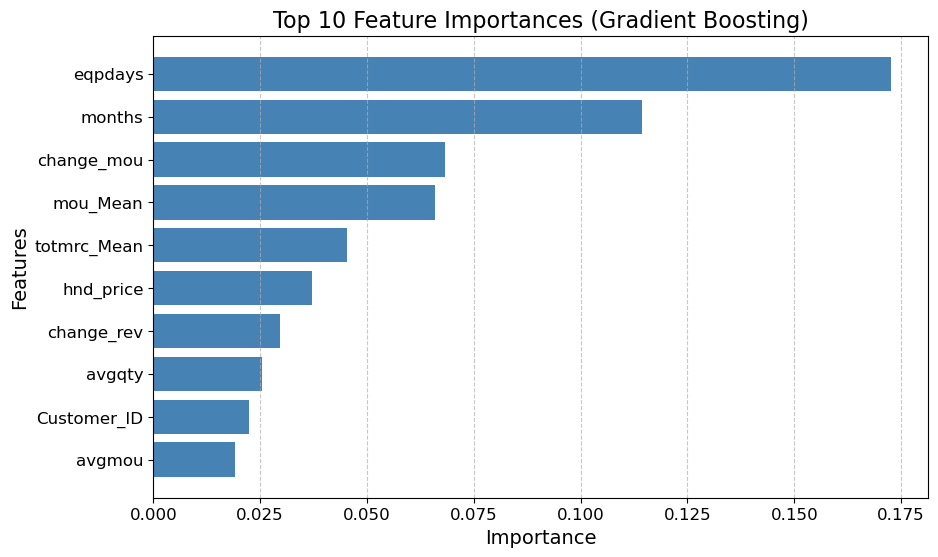

In [23]:
# Извлечение важности признаков
feature_importances = gb_search.best_estimator_.named_steps['classifier'].feature_importances_

# Получение имен признаков
feature_names = np.concatenate([
    num_features,
    gb_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features)
])

# Создание DataFrame для визуализации важности признаков
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Выбор 10 самых важных признаков
top_10_importances_df = importances_df.head(10)

# Вывод 10 самых важных признаков
print("Top 10 important features:")
print(top_10_importances_df[['Feature', 'Importance']])

# Визуализация важности 10 самых важных признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_importances_df['Feature'], top_10_importances_df['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Importances (Gradient Boosting)', fontsize=16)
plt.gca().invert_yaxis()  # Инвертируем ось Y для убывающего порядка
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавляем сетку для удобства
plt.show()

In [ ]:
''' итак, интерпретировать полученный результат будем по тому же принципу, что и в первом задании
eqpdays - самый значимый показатель: количество дней, прошедшее с момента последней активности
months - вероятно, это количество месяцев, которые клиент использует услугу. Долгосрочные клиенты имеют меньшую вероятность ухода 
change_mou - если клиент уменьшает оличество минут использования. это может указывать на потенциальный отток
mou_Mean - высокие значения среднего количества минут использования могут указывать на удовлетворенность клиента
totmrc_Mean - похоже на средний месячный доход от клиента. Важно для определения прибыльности и надежностиклиента
hnd_price - похоже на цену за устройство. Высокая цена может способствовать уходу клиентов
change_rev - похоже на изменение в доходах от клиента. Снижение доходов должно насторожить на предмет ухода.
avgqty - похоже на среднее количество услуг или товаров, используемых клиентом. Это может быть индикатором вовлеченности.
Customer_ID - Идентификатор клиента, может использоваться для отслеживания.
avgmou - похоже на среднее количество минут использования, как и Как и mou_Mean скорее всего говорит об удовлетворенности клиента'''